## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
df = pd.read_csv('WineQT.csv', index_col="Id")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Examining data

In [3]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<AxesSubplot:xlabel='Id'>

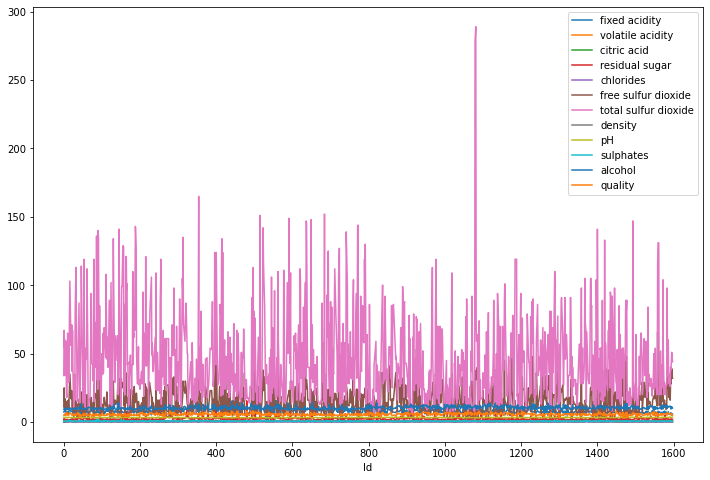

In [4]:
df.plot(figsize=(12,8))

### Outliers

#### Total Sulfur Dioxide

In [5]:
# At this scale, the only outliers visible are ones with large total sulfur dioxide values. Let's examine them.
df.loc[df["total sulfur dioxide"] > 250]

# These two rows are identical aside from slightly different (but sitll unusually high) total sulfur dioxide counts. This is suspicous. We might want to drop these.

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
1079,7.9,0.3,0.68,8.3,0.05,37.5,278.0,0.99316,3.01,0.51,12.3,7
1081,7.9,0.3,0.68,8.3,0.05,37.5,289.0,0.99316,3.01,0.51,12.3,7


<AxesSubplot:xlabel='Id'>

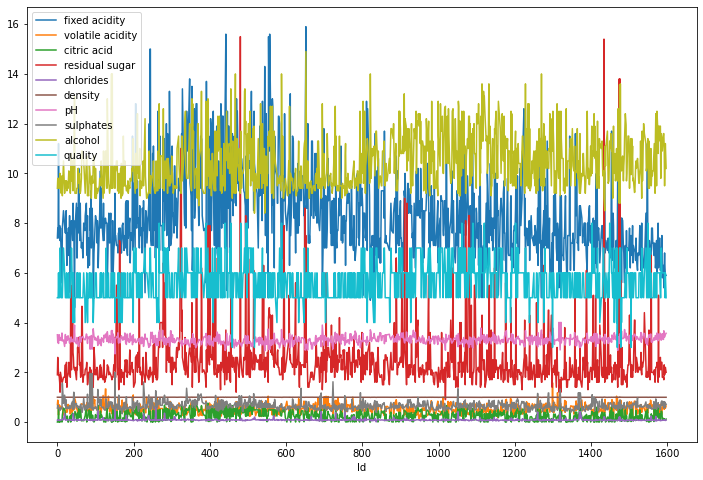

In [6]:
df.drop(["total sulfur dioxide", "free sulfur dioxide"], axis=1).plot(figsize=(12,8))

#### Residual Sugar

In [7]:
# Still hard to see what is going on here, but there are a couple red spikes indicating high sugar content.
df["residual sugar"].describe()

count    1143.000000
mean        2.532152
std         1.355917
min         0.900000
25%         1.900000
50%         2.200000
75%         2.600000
max        15.500000
Name: residual sugar, dtype: float64

In [8]:
# Now the question is: Are these outliers? Or is this just some really sweet wine?
sugar_outliers = df.loc[
    df["residual sugar"] > 
    df["residual sugar"].mean() + 
    df["residual sugar"].std() * 7
]
sugar_outliers

# How many standard deviations are too many standard deviations? Ask your local sommelier and find out. Then drop these guys if you wish.
# df = df.drop(sugar_outliers.index)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
480,10.6,0.28,0.39,15.5,0.069,6.0,23.0,1.00260,3.12,0.66,9.2,5
1434,10.2,0.54,0.37,15.4,0.214,55.0,95.0,1.00369,3.18,0.77,9.0,6
1474,9.9,0.50,0.50,13.8,0.205,48.0,82.0,1.00242,3.16,0.75,8.8,5
1476,9.9,0.50,0.50,13.8,0.205,48.0,82.0,1.00242,3.16,0.75,8.8,5


## Building a model

### Overview
We will build two models here. One with the absolute bare minimum data preprocessing and one where we include the usuage of data normalization

### Base model

In [9]:
# Try changing random state and check the MAE differential between the two models.
random_state = 11
features = df.columns.drop("quality")
x = df[features]
y = df.quality

train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=random_state)

base_model = DecisionTreeRegressor(random_state=random_state)
base_model.fit(train_x, train_y)

base_predictions = base_model.predict(val_x)
base_mae = mean_absolute_error(base_predictions, val_y)
print("Base MAE: {:.5f}".format(base_mae))

Base MAE: 0.47552


### Normalized model

In [10]:
df_norm = df.copy()

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

for col in df_norm.columns.drop("quality"):
    df_norm[col] = min_max_scaling(df_norm[col])

df_norm.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,0.328417,0.281739,0.268364,0.111791,0.125096,0.218142,0.141041,0.489017,0.449618,0.196232,0.314171,5.657043
std,0.154654,0.123036,0.196686,0.092871,0.078910,0.152992,0.115838,0.141341,0.123358,0.102035,0.166492,0.805824
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.221239,0.186644,0.090000,0.068493,0.096828,0.089552,0.053004,0.403818,0.366142,0.131737,0.169231,5.000000
50%,0.292035,0.273973,0.250000,0.089041,0.111853,0.179104,0.109541,0.485316,0.448819,0.173653,0.276923,6.000000
75%,0.398230,0.356164,0.420000,0.116438,0.130217,0.298507,0.194346,0.570852,0.519685,0.239521,0.415385,6.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [11]:
features = df_norm.columns.drop("quality")
x = df_norm[features]
y = df_norm.quality

train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=1)

norm_model = DecisionTreeRegressor(random_state=random_state)
norm_model.fit(train_x, train_y)

norm_predictions = norm_model.predict(val_x)
norm_mae = mean_absolute_error(norm_predictions, val_y)
print("Normalized MAE: {:.5f}".format(norm_mae))

Normalized MAE: 0.48601


In [12]:
print("Normalized model has {} {} MAE".format(abs(norm_mae - base_mae), "lower" if norm_mae <= base_mae else "higher" ))

Normalized model has 0.010489510489510467 higher MAE


In [13]:
df_mae = pd.DataFrame({"base": [], "norm": [], "diff": []}, dtype="float64")

# Change this range() to influence the amount of iterations. Try not to brick your PC though.
random_states = range(1, 2976221, 4567)

# Data splits are placed outside the loop with a fixed random_state. Feel free to experiment by commenting/uncommenting code to move them inside the loop. But be aware that this will require more computational power.
base_train_x, base_val_x, base_train_y, base_val_y = train_test_split(df[features], df.quality, random_state=1)
norm_train_x, norm_val_x, norm_train_y, norm_val_y = train_test_split(df_norm[features], df_norm.quality, random_state=1)

for r in random_states:
    # base_train_x, base_val_x, base_train_y, base_val_y = train_test_split(df[features], df.quality, random_state=r)
    # norm_train_x, norm_val_x, norm_train_y, norm_val_y = train_test_split(df_norm[features], df_norm.quality, random_state=r)

    base_model = DecisionTreeRegressor(random_state=r)
    norm_model = DecisionTreeRegressor(random_state=r)

    base_model.fit(base_train_x, base_train_y)
    norm_model.fit(norm_train_x, norm_train_y)

    base_predictions = base_model.predict(base_val_x)
    norm_predictions = norm_model.predict(norm_val_x)

    base_mae = mean_absolute_error(base_predictions, base_val_y)
    norm_mae = mean_absolute_error(norm_predictions, norm_val_y)

    diff_mae = norm_mae - base_mae
    df_mae.loc[r] = [base_mae, norm_mae, diff_mae]

# Note the mean value here. Positive values in the diff column mean the normalized model is performing better.
df_mae["diff"].describe()

count    652.000000
mean       0.000338
std        0.002625
min       -0.010490
25%        0.000000
50%        0.000000
75%        0.003497
max        0.006993
Name: diff, dtype: float64

Text(0, 0.5, 'Normalized Model')

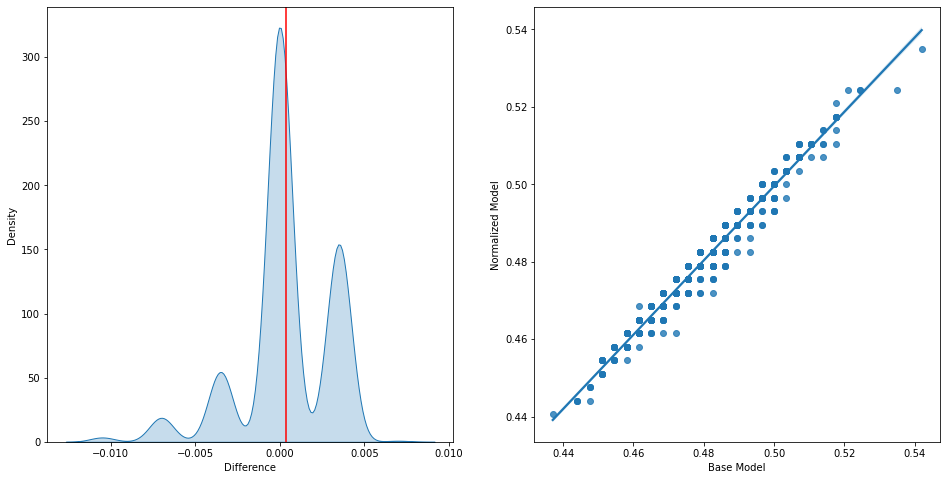

In [14]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.kdeplot(df_mae["diff"], shade=True)
plt.axvline(df_mae["diff"].mean(), color="red")
plt.xlabel(xlabel="Difference")

plt.subplot(1,2,2)
sns.regplot(x=df_mae["base"], y=df_mae["norm"])
plt.xlabel(xlabel="Base Model")
plt.ylabel(ylabel="Normalized Model")


## Confusion Matrix

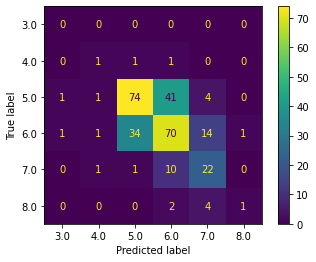

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_pred=norm_predictions.round(), y_true=val_y.round())

## Conclusions:

There are none. In this dataset at least, the MAE difference between the two models is both insignificant and unpredictable. By changing random_state and rerunning the code cells, the MAE fluctuates drastically. Sometimes the normalized model performs better, sometimes the base model does better. Sometimes there is literally no difference. (Try random_state = 1)

There is a *very* slight increase in model performance when using normalized data as visualized in the above graph however the difference is so marginal that it is difficult to tell if this difference is meaningful or not. Furthermore, experimenting with different inputs for the random_state variable can also create mean averages with negative values, adding further confusion.

Perhaps by exploring this technique on larger datasets with better feature engineering, a more impactful differnce may be observed.